# 5.3.1 例題 : 株価の予測

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [19]:
using Distributions
using Optim
using Plots
using Statistics

In [3]:
function stock_loss(true_return, yhat, alpha = 100)
    if true_return * yhat < 0
        alpha * yhat ^ 2 - sign(true_return) * yhat + abs(true_return)
    else
        abs(true_return - yhat)
    end
end

stock_loss (generic function with 2 methods)

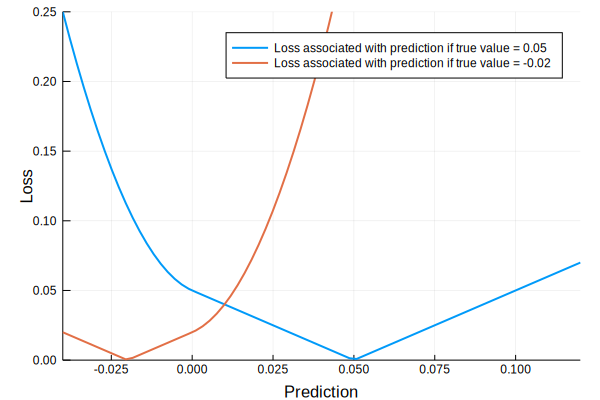

In [4]:
pred = range(-0.04, length = 75, stop = 0.12)

true_value = 0.05
Plots.plot(pred, stock_loss.(true_value, pred), linewidth = 2,
    label = "Loss associated with prediction if true value = 0.05")

true_value = -0.02
Plots.plot!(pred, stock_loss.(true_value, pred), linewidth = 2, 
    label = "Loss associated with prediction if true value = -0.02",
    xlabel = "Prediction", ylabel = "Loss",
    xlims = (-0.04, 0.12), ylims = (0, 0.25))

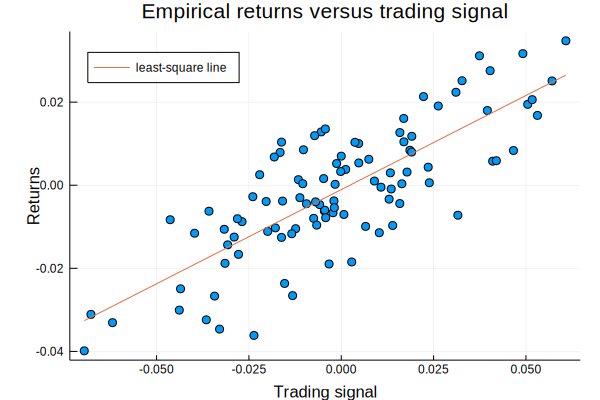

In [5]:
# シミュレーションデータの作成
N = 100
X = 0.025 * rand(Normal(), N)
Y = 0.5 * X + 0.01 * rand(Normal(), N)

ls_coef = cov(X, Y) / var(X)
ls_intercept = mean(Y) - ls_coef * mean(X)

scatter(X, Y, label = "")
Plots.plot!(X, ls_coef * X .+ ls_intercept, label = "least-square line", legend = :topleft,
    xlabel = "Trading signal", ylabel = "Returns",
    title = "Empirical returns versus trading signal")

In [6]:
model = Model(
    std = Stochastic(() -> Uniform(0, 100)),
    beta = Stochastic(() -> Normal(0, 100)),
    alpha = Stochastic(() -> Normal(0, 100)),
    mean_ = Logical(1, (X, alpha, beta) -> alpha .+ beta .* X),
    obs = Stochastic(1, 
        (mean_, std) -> MvNormal(mean_, std),
        false
    ),
)

Object of type "Model"
-------------------------------------------------------------------------------
std:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mean_:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [7]:
data = Dict(
    :X => X,
    :obs => Y
)

Dict{Symbol,Array{Float64,1}} with 2 entries:
  :obs => [0.0223775, -0.00830734, -0.00335417, -0.00662337, 0.0275637, -0.0300…
  :X   => [0.0310505, -0.0463114, 0.0129558, -0.00223845, 0.0403021, -0.0438422…

In [8]:
inits = [
    Dict(
        :std => 1,
        :beta => 0,
        :alpha => 0,
        :mean_ => zeros(length(X)),
        :obs => Y,
    )
    for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:std=>1,:alpha=>0,:beta=>0,:mean_=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:obs=>[0.0223775, -0.00830734, -0.00335417, -0.00662337, 0.0275637, -0.0300621, 0.00578264, 0.00316949, -0.0114315, -0.00991204  …  0.00329211, 0.0205985, 0.0190671, -0.0116781, 0.00133806, 0.00590108, 0.000362802, 0.0316774, -0.00400482, 0.00101038])
 Dict(:std=>1,:alpha=>0,:beta=>0,:mean_=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:obs=>[0.0223775, -0.00830734, -0.00335417, -0.00662337, 0.0275637, -0.0300621, 0.00578264, 0.00316949, -0.0114315, -0.00991204  …  0.00329211, 0.0205985, 0.0190671, -0.0116781, 0.00133806, 0.00590108, 0.000362802, 0.0316774, -0.00400482, 0.00101038])
 Dict(:std=>1,:alpha=>0,:beta=>0,:mean_=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:obs=>[0.0223775, -0.008

In [9]:
scheme = [AMWG([:std, :beta, :alpha], 1)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:std, :beta, :alpha]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 100000, burnin = 80000, thin = 3, chains = 3)

MCMC Simulation of 100000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [10:26:25 of 10:26:29 remaining]
      From worker 4:	Chain 2:   0% [10:29:23 of 10:29:27 remaining]
      From worker 3:	Chain 3:   0% [10:38:48 of 10:38:52 remaining]
      From worker 2:	Chain 1:  10% [0:00:42 of 0:00:47 remaining]
      From worker 4:	Chain 2:  10% [0:00:42 of 0:00:47 remaining]
      From worker 3:	Chain 3:  10% [0:00:42 of 0:00:47 remaining]
      From worker 2:	Chain 1:  20% [0:00:22 of 0:00:27 remaining]
      From worker 4:	Chain 2:  20% [0:00:23 of 0:00:28 remaining]
      From worker 3:	Chain 3:  20% [0:00:23 of 0:00:28 remaining]
      From worker 2:	Chain 1:  30% [0:00:15 of 0:00:21 remaining]
      From worker 3:	Chain 3:  30% [0:00:15 of 0:00:22 remaining]
      From worker 4:	Chain 2:  30% [0:00:15 of 0:00:22 remaining]
      From worker 2:	Chain 1:  40% [0:00:11 of 0:00:18 remaining]
      From worker 3:	Chain 3:  40% [0:00:11 of 0:00:18 remaining]
      From worker 

Object of type "ModelChains"

Iterations = 80003:99998
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 6666

[0.443711 0.000206844 … 0.0041916 0.00933593; 0.476001 0.000156368 … 0.0044311 0.00903033; … ; 0.460875 -0.00158274 … 0.00255616 0.00926675; 0.460875 -0.00158274 … 0.00255616 0.00969135]

[0.502201 -0.000128846 … 0.00438118 0.0103141; 0.422878 -0.00014932 … 0.00364835 0.00939561; … ; 0.449268 -0.000743683 … 0.00329097 0.00956323; 0.485556 -0.000743683 … 0.00361686 0.00956323]

[0.401276 -0.00125185 … 0.00235182 0.0108135; 0.440487 -0.00125185 … 0.00270395 0.00952188; … ; 0.458559 -0.00165857 … 0.00245952 0.0100382; 0.458559 -0.00165857 … 0.00245952 0.0100382]

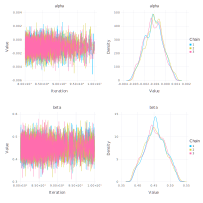

In [11]:
p = Mamba.plot(sim[:, [:alpha, :beta], :], legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

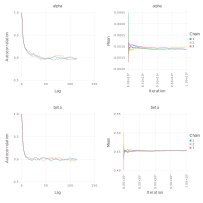

In [12]:
p = Mamba.plot(sim[:, [:alpha, :beta], :],  [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

In [45]:
function stock_loss(price, pred, coef = 500)
    sol = zeros(length(price))
    ix = price .* pred .< 0
    sol[ix] = @.(coef * pred^2 - sign(price[ix]) * pred + abs(price[ix]))
    sol[.!ix] = @.(abs(price[.!ix] - pred))
    sol
end

stock_loss (generic function with 2 methods)

In [51]:
std_samples = sim[:, :std, :].value[:]
alpha_samples = sim[:, :alpha, :].value[:]
beta_samples = sim[:, :beta, :].value[:]

N = length(tau_samples)
noise = std_samples .* rand(Normal(), N)

opt_predictions = zeros(50)
trading_signals = range(minimum(X), length = 50, stop = maximum(X))

-0.06957440404185974:0.0026608189869858113:0.06080572632044501

In [54]:
possible_outcomes(signal) = alpha_samples .+ beta_samples .* signal .+ noise

for (i, signal) in enumerate(trading_signals)
    function tomin(pred)
        possible_outcomes_ = possible_outcomes(signal)
        mean(stock_loss(possible_outcomes_, pred))
    end
    
    opt_predictions[i] = Optim.minimizer(optimize(tomin, -1.0, 1.0))
end

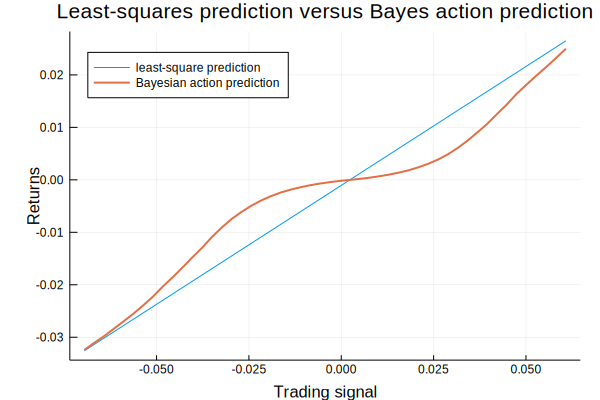

In [61]:
Plots.plot(X, ls_coef .* X .+ ls_intercept, label = "least-square prediction", legend = :topleft,
    xlabel = "Trading signal", ylabel = "Returns",
    title = "Least-squares prediction versus Bayes action prediction")
Plots.plot!(trading_signals, opt_predictions, linewidth = 2, label = "Bayesian action prediction")